In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import data

In [557]:
X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

# Feature Engineering
We will add more features based on domain knowledge or by extracting from other features thagt can help give better predictions.

After carefully understanding the features, we divided them in meaningful subgroups to analyze. 

In [559]:
feature_groups = {
    'jitter': ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP'],
    'shimmer': ['Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'Shimmer(dB)'],
    'noise': ['NHR', 'HNR'],
    'nonlinear': ['RPDE', 'DFA', 'PPE']
}

In [560]:
def create_subgroup_aggregates(X, feature_groups):
    """
    Creates mean/std features for each clinically defined subgroup
    """
    X_engineered = X.copy()
    
    for group_name, features in feature_groups.items():
        # Use only features present in the DataFrame
        valid_features = [f for f in features if f in X.columns]
        
        if valid_features:  # Check if features exist
            X_engineered[f'{group_name}_mean'] = X[valid_features].mean(axis=1)
            X_engineered[f'{group_name}_std'] = X[valid_features].std(axis=1)
    
    return X_engineered

# Apply to train and test sets
X_train_engineered = create_subgroup_aggregates(X_train_scaled, feature_groups)
X_test_engineered = create_subgroup_aggregates(X_test_scaled, feature_groups)

In [561]:
# voice specific global measures
voice_features = feature_groups['jitter'] + feature_groups['shimmer'] + feature_groups['noise']
X_train_engineered['voice_instability'] = X_train_scaled[voice_features].mean(axis=1)
X_test_engineered['voice_instability'] = X_test_scaled[voice_features].mean(axis=1)

In [562]:
X_test_engineered.columns

Index(['sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'PPE', 'age',
       'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability'],
      dtype='object')

In [563]:
interaction_pairs = [
    # Voice instability interactions
    ('Jitter(%)', 'Shimmer'),               # Combined voice instability
    ('NHR', 'HNR'),                         # Noise/harmonic balance
    ('RPDE', 'PPE'),                        # Nonlinear dynamics combo
    ('jitter_mean', 'shimmer_mean'),        # Subgroup aggregates
    ('age', 'DFA')                          # Age-related signal degradation
]

In [ ]:
def create_interactions(X, interaction_pairs):
    """Create clinically relevant interaction terms"""
    X_new = X.copy()
    for f1, f2 in interaction_pairs:
        if f1 in X.columns and f2 in X.columns:
            X_new[f'{f1}_x_{f2}'] = X[f1] * X[f2]
    return X_new

X_train_engineered = create_interactions(X_train_engineered, interaction_pairs)
X_test_engineered = create_interactions(X_test_engineered, interaction_pairs)

In [565]:
X_train_engineered.columns

Index(['sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'PPE', 'age',
       'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability',
       'Jitter(%)_x_Shimmer', 'NHR_x_HNR', 'RPDE_x_PPE',
       'jitter_mean_x_shimmer_mean', 'age_x_DFA'],
      dtype='object')

In [566]:
polynomial_features = [
    'Jitter(%)',    # Often shows quadratic relationship with severity
    'PPE',          # Entropy measures frequently have diminishing returns
    'age',          # Age effects may accelerate
    'test_time'     # Disease progression often nonlinear
]

In [567]:
def create_polynomials(X, features, degree=2):
    """Add polynomial features for selected columns"""
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X[features])
    feature_names = poly.get_feature_names_out(features)

    # Remove original features to avoid redundancy
    X = X.drop(columns=features, errors='ignore')
    return pd.concat([X, pd.DataFrame(poly_features, columns=feature_names, index=X.index)], axis=1)

X_train_engineered = create_polynomials(X_train_engineered, polynomial_features)
X_test_engineered = create_polynomials(X_test_engineered, polynomial_features)

In [568]:
X_train_engineered.columns

Index(['sex', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11',
       'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'Shimmer(dB)', 'HNR',
       'jitter_mean', 'jitter_std', 'shimmer_mean', 'shimmer_std',
       'noise_mean', 'noise_std', 'nonlinear_mean', 'nonlinear_std',
       'voice_instability', 'Jitter(%)_x_Shimmer', 'NHR_x_HNR', 'RPDE_x_PPE',
       'jitter_mean_x_shimmer_mean', 'age_x_DFA', 'Jitter(%)', 'PPE', 'age',
       'test_time', 'Jitter(%)^2', 'Jitter(%) PPE', 'Jitter(%) age',
       'Jitter(%) test_time', 'PPE^2', 'PPE age', 'PPE test_time', 'age^2',
       'age test_time', 'test_time^2'],
      dtype='object')

In [569]:
print(len(X_train_engineered.columns))
print(len(set(X_train_engineered.columns)))

43
43


### Preprocess the data

In [570]:
# check if min max is outside of 0-1 range
X_train_engineered.describe()

,sex,Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,...,Jitter(%)^2,Jitter(%) PPE,Jitter(%) age,Jitter(%) test_time,PPE^2,PPE age,PPE test_time,age^2,age test_time,test_time^2
count,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,...,4.319000e+03,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000
mean,0.321139,0.000039,0.002511,0.002715,0.007533,0.030499,0.015398,0.017834,0.024884,0.046192,...,3.440436e-05,0.001263,0.002915,0.002258,0.049464,0.115868,0.089320,0.370481,0.234106,0.247540
std,0.466968,0.000025,0.001433,0.001428,0.004298,0.019493,0.010414,0.012049,0.015873,0.031242,...,3.796222e-05,0.001135,0.002176,0.001839,0.038577,0.078196,0.065439,0.296638,0.194480,0.226119
min,0.000000,0.000002,0.000330,0.000430,0.000980,0.003060,0.001610,0.001940,0.002490,0.004840,...,6.889000e-07,0.000020,0.000000,0.000000,0.000483,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000021,0.001490,0.001720,0.004460,0.017970,0.008615,0.010110,0.014675,0.025840,...,1.156000e-05,0.000516,0.001211,0.000942,0.022283,0.050011,0.039387,0.096314,0.082833,0.049448
50%,0.000000,0.000032,0.002120,0.002370,0.006350,0.025900,0.012700,0.014930,0.021560,0.038110,...,2.152960e-05,0.000927,0.002450,0.001827,0.039101,0.103481,0.075865,0.304400,0.179640,0.178398
75%,1.000000,0.000050,0.003130,0.003330,0.009380,0.037040,0.019035,0.021865,0.030710,0.057115,...,4.147360e-05,0.001609,0.004154,0.003074,0.064969,0.174084,0.124871,0.629013,0.348634,0.411787
max,1.000000,0.000167,0.008300,0.012570,0.024910,0.239150,0.162670,0.162460,0.205850,0.488020,...,3.161284e-04,0.009385,0.012207,0.013562,0.311665,0.388459,0.419515,1.000000,0.985581,1.000000


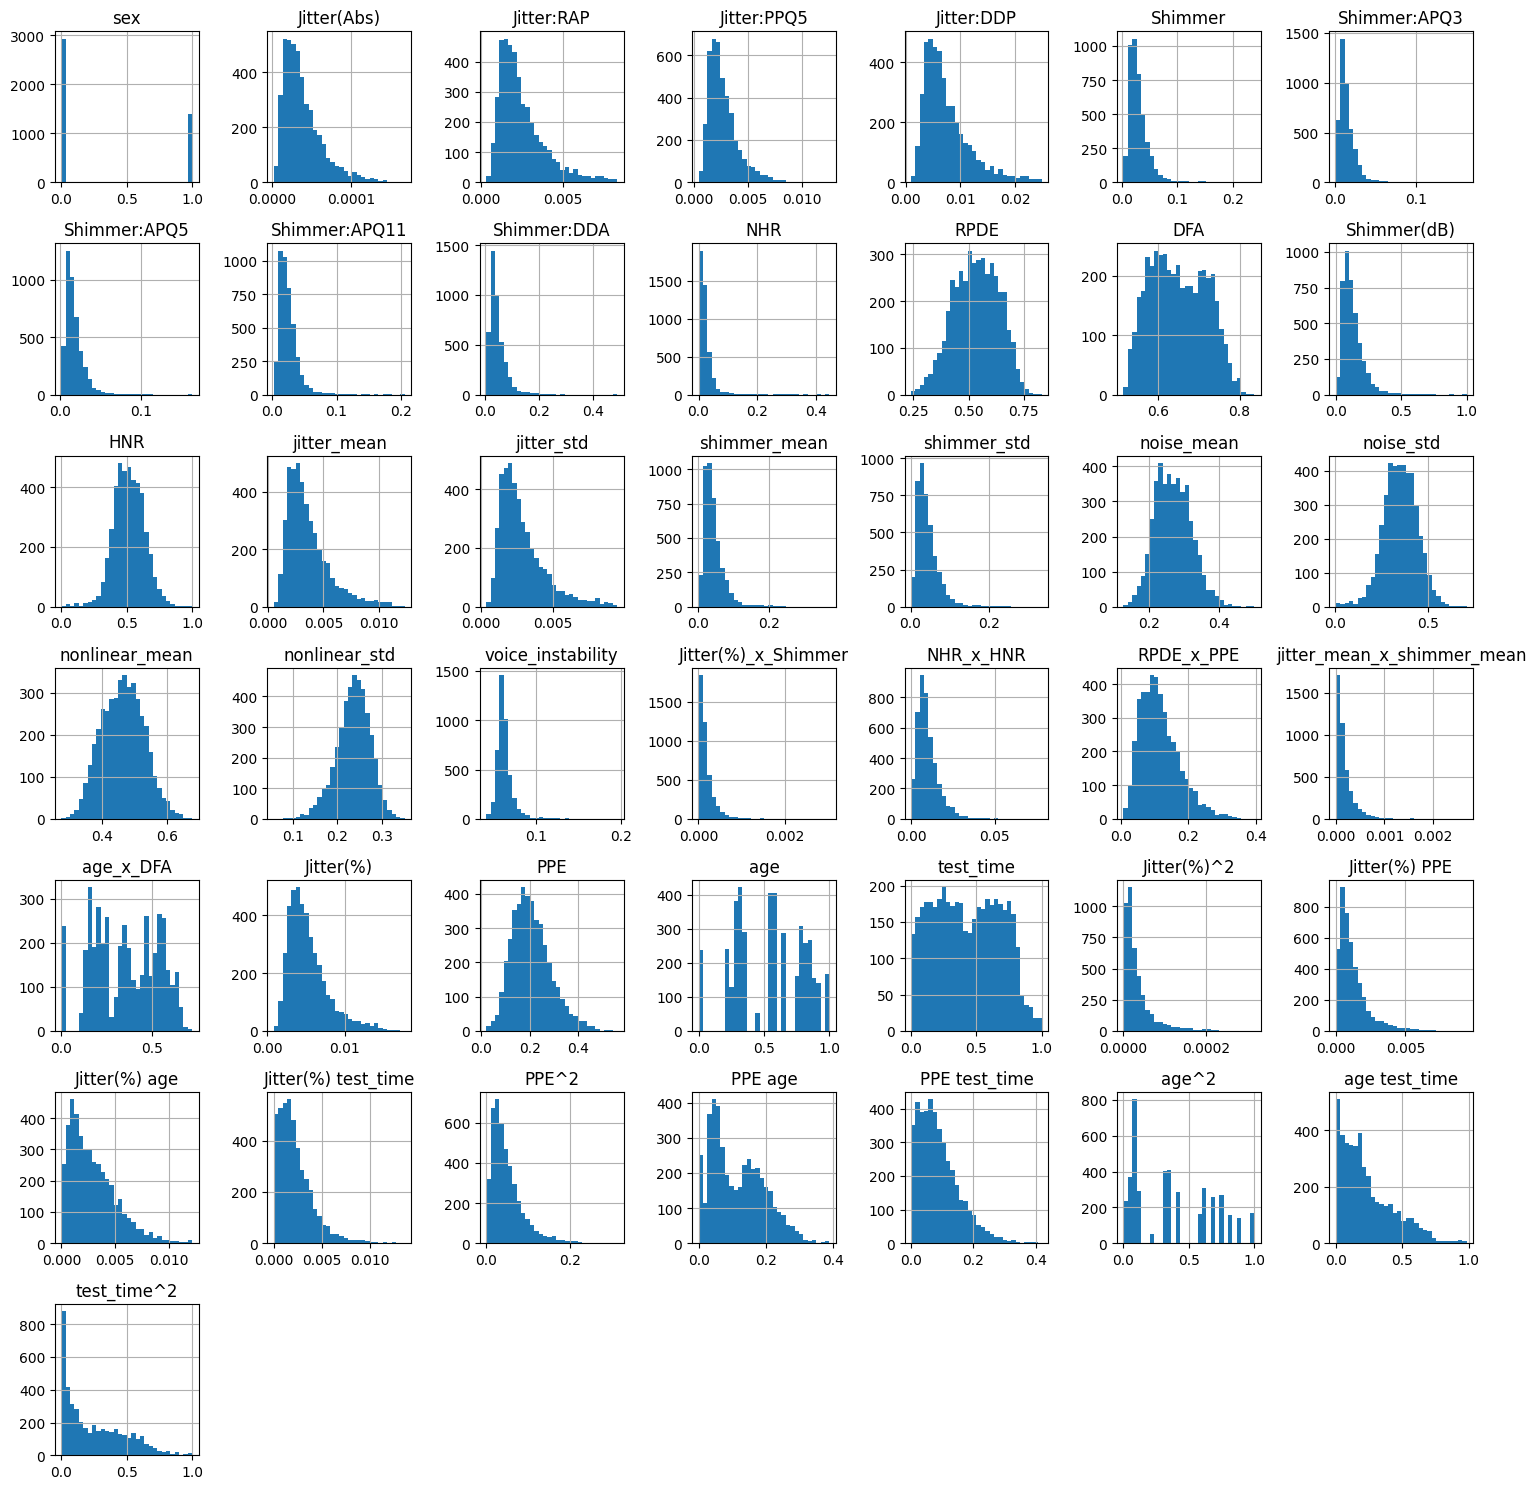

Skewness of features:
 NHR                           6.454374
Jitter(%)_x_Shimmer           4.077808
jitter_mean_x_shimmer_mean    4.001420
voice_instability             3.104327
Shimmer:APQ11                 3.069720
Shimmer:APQ5                  2.865452
Shimmer                       2.768091
Shimmer:DDA                   2.748309
Shimmer:APQ3                  2.748257
Jitter(%)^2                   2.691087
shimmer_std                   2.656665
Shimmer(dB)                   2.640879
shimmer_mean                  2.634773
Jitter(%) PPE                 2.243524
NHR_x_HNR                     2.100259
PPE^2                         1.756361
Jitter(%) test_time           1.703871
Jitter:PPQ5                   1.663037
Jitter(Abs)                   1.484635
Jitter:DDP                    1.427376
Jitter:RAP                    1.427367
jitter_std                    1.421079
jitter_mean                   1.412021
Jitter(%)                     1.338358
PPE test_time                 1.117490
Ji

In [571]:
# check distribution and skewness of features

# Plot histograms for all features
X_train_engineered.hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.show()

# Quantify skew (threshold: |skew| > 1 is significant)
skewness = X_train_engineered.skew()
print("Skewness of features:\n", skewness.sort_values(ascending=False))

### Tranformation

- Strong transform needed: skew > 2
- Moderate transform needed: skew <= 2
- No tranform needed: skew <= 1

Apply Yeo-Johnson tranform to all since it automatically handles positive, negative and zero values; reduces skewness without manual tuning; works for all model types

In [ ]:
def apply_power_transformer(X_train, X_test):
    """Apply PowerTransformer to train and test sets"""
    preprocessor = PowerTransformer(method='yeo-johnson')
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # return dfs with original column names
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)

    return X_train_transformed, X_test_transformed

# Apply to train and test sets
X_train_engineered, X_test_engineered = apply_power_transformer(X_train_engineered, X_test_engineered)

In [573]:
# After PowerTransformer, values should be ~[-3,3]
print("Post-PowerTransformer range:", 
      f"[{X_train_engineered.min().min():.2f}, {X_train_engineered.max().max():.2f}]")

Post-PowerTransformer range: [-4.21, 4.49]


Top skewed features after transform:
 sex                           0.766406
Jitter(%)^2                   0.436162
jitter_mean_x_shimmer_mean    0.426469
Jitter(%)_x_Shimmer           0.386235
NHR                           0.314490
Jitter(%) PPE                 0.286784
PPE^2                         0.177619
Shimmer:APQ3                  0.175277
Jitter:RAP                    0.171979
Jitter:DDP                    0.170544
dtype: float64


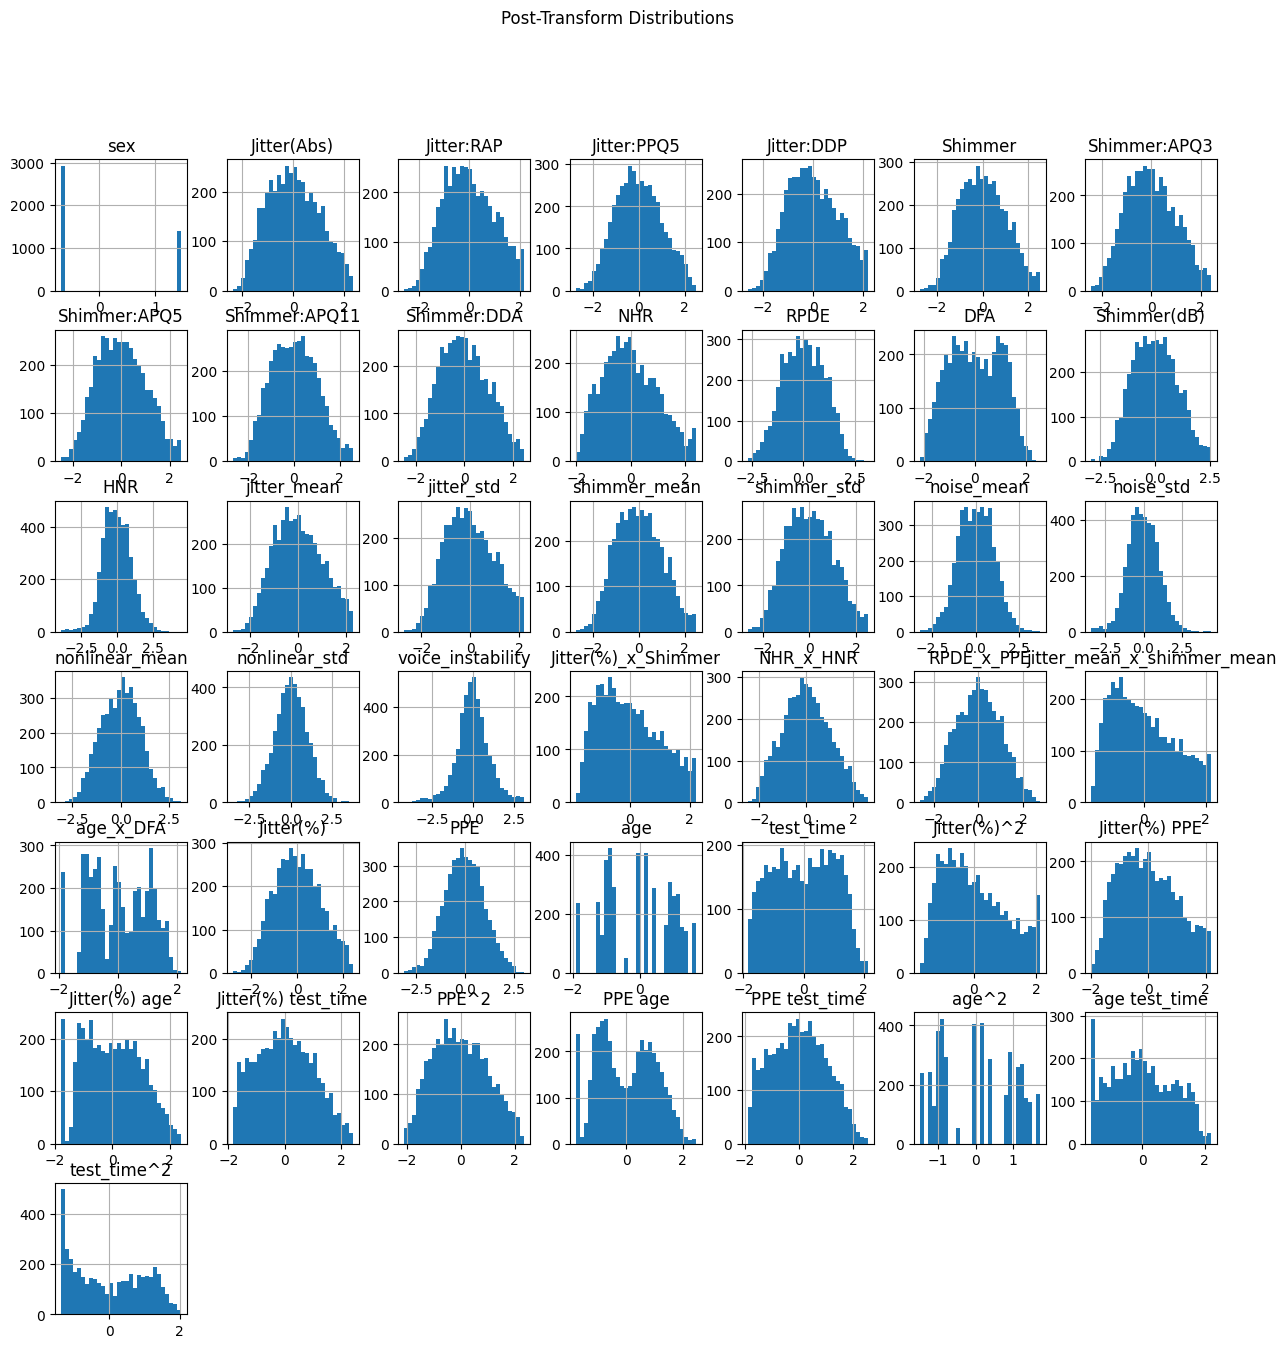

In [574]:
# Check post-transform skewness
skewness_after = X_train_engineered.skew().sort_values(key=abs, ascending=False)
print("Top skewed features after transform:\n", skewness_after.head(10))

# Plot histograms
X_train_engineered.hist(bins=30, figsize=(15, 15))
plt.suptitle("Post-Transform Distributions")
plt.show()

### Scaling

In [575]:
# # Case 1: All features already 0-1 (no action needed)
# if (X_train_engineered.min().min() >= 0) and (X_train_engineered.max().max() <= 1):
#     print("Data already normalized to [0,1] — no scaling needed.")
    
# # Case 2: Some features outside 0-1
# else:
#     from sklearn.preprocessing import MinMaxScaler
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_train_scaled = scaler.fit_transform(X_train_engineered)
#     X_test_scaled = scaler.transform(X_test_engineered)

In [576]:
# X_train_engineered.hist(bins=30, figsize=(15, 15))
# plt.suptitle("Post-Transform and Scale Distributions")
# plt.show()

# Result

In [ ]:
# check if they improve prediction

# Baseline (original features)
baseline = LinearRegression().fit(X_train_scaled, y_train_motor)
baseline_mae = mean_absolute_error(y_test_motor, baseline.predict(X_test_scaled))
baseline_mse = mean_squared_error(y_test_motor, baseline.predict(X_test_scaled))
baseline_r2 = r2_score(y_test_motor, baseline.predict(X_test_scaled))

# Engineered features
engineered = LinearRegression().fit(X_train_engineered, y_train_motor)
engineered_mae = mean_absolute_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_mse = mean_squared_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_r2 = r2_score(y_test_motor, engineered.predict(X_test_engineered))

print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"Baseline MSE: {baseline_mse:.3f}")
print(f"Baseline R2: {baseline_r2:.3f}")
print(f"With New Features MAE: {engineered_mae:.3f}")
print(f"With New Features MSE: {engineered_mse:.3f}")
print(f"With New Features R2: {engineered_r2:.3f}")

Baseline MAE: 6.615
Baseline MSE: 55.254
Baseline R2: -0.719
With New Features MAE: 5.573
With New Features MSE: 45.315
With New Features R2: -0.410


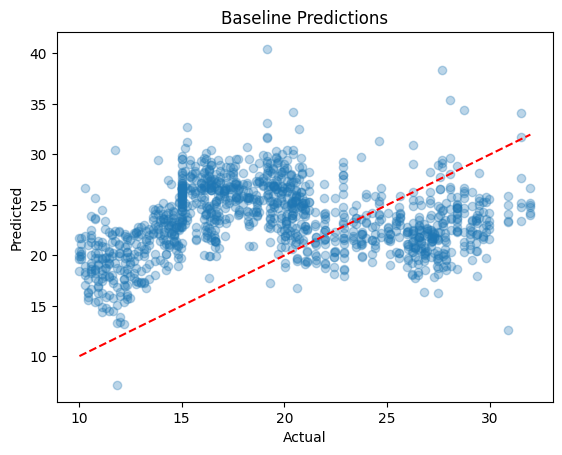

In [578]:
plt.scatter(y_test_motor, baseline.predict(X_test_scaled), alpha=0.3)
plt.plot([y_test_motor.min(), y_test_motor.max()], [y_test_motor.min(), y_test_motor.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Baseline Predictions")
plt.show()

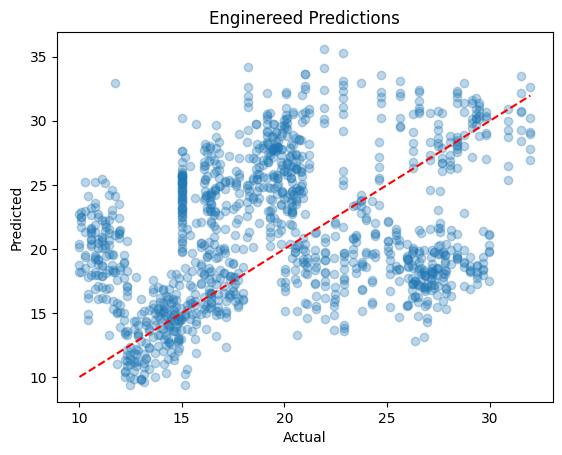

In [579]:
plt.scatter(y_test_motor, engineered.predict(X_test_engineered), alpha=0.3)
plt.plot([y_test_motor.min(), y_test_motor.max()], [y_test_motor.min(), y_test_motor.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Enginereed Predictions")
plt.show()

We have improvement in prediction.

In [581]:
X_train_engineered.to_pickle('data/X_train_engineered.pkl')
X_test_engineered.to_pickle('data/X_test_engineered.pkl')